In [26]:
import pandas as pd
import numpy as np
# from geopy.geocoders import Nominatim
from tqdm import tqdm, trange

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties

In [27]:
dataset = pd.read_csv('1k_refah_db_clean.zip')
dataset.shape

(28205, 48)

In [28]:
print('number of people:', len(dataset['ParentID']))
print('number of families:', len(np.unique(dataset['ParentID'])))

number of people: 28205
number of families: 9473


In [29]:
# "families" is a dictionary from the parentID to all family members' IDs
families = dict()
for parent in np.unique(dataset['ParentID']):
    families[parent] = []
for i in range(len(dataset)):
    families[dataset.loc[i, "ParentID"]].append(dataset.loc[i, "ID"])
pops = np.unique(list(len(families[item]) for item in list(families.keys())))
families_pops = [0] * (pops[-1]+1)
for i in pops:
    families_pops[i] = sum(len(value) == i for value in families.values())
families_pops = families_pops[1:]

In [31]:
def logalize(number):
    return np.log10(number+1)

In [36]:
def family_similarity_matrix(family1, family2):
    array = np.zeros(len(family1))
    for i in range(len(array)):
        array[i] = (i+1)*pow(abs(family1[i] - family2[i]), 2)
    return sum(array)

In [47]:
def calc_similarity_column(all_families_Am, i):
    family = all_families_Am[i]
    return (np.dot([1, 2, 3, 4], (pow(all_families_Am-family.reshape(1, -1), 2).T))).T


## family AmCrdtrs & AmDbtrs

In [32]:
def count_fam_AmCrdtrs_and_AmDbtrs(dataset, family):
    total_AmCrdtr_95, total_AmCrdtr_96, total_AmCrdtr_97, total_AmCrdtr_98 = 0, 0, 0, 0
    total_AmDbtr_95, total_AmDbtr_96, total_AmDbtr_97, total_AmDbtr_98 = 0, 0, 0, 0

    for person in family:
        cell = dataset.loc[dataset.ID == person]
        #AmCrdtrs
        total_AmCrdtr_95 += list(cell['AmCrdtr_95'])[0]
        total_AmCrdtr_96 += list(cell['AmCrdtr_96'])[0]
        total_AmCrdtr_97 += list(cell['AmCrdtr_97'])[0]
        total_AmCrdtr_98 += list(cell['AmCrdtr_98'])[0]
        
        #AmDbtrs
        total_AmDbtr_95 += list(cell['Amdbtr_95'])[0]
        total_AmDbtr_96 += list(cell['Amdbtr_96'])[0]
        total_AmDbtr_97 += list(cell['Amdbtr_97'])[0]
        total_AmDbtr_98 += list(cell['Amdbtr_98'])[0]
    
    all_data = [total_AmCrdtr_95, total_AmCrdtr_96, total_AmCrdtr_97, total_AmCrdtr_98, total_AmDbtr_95, total_AmDbtr_96, total_AmDbtr_97, total_AmDbtr_98]
    for i in range(len(all_data)):
        all_data[i] = logalize(all_data[i])

    return all_data[0:4], all_data[4:8]

In [34]:
family_AmCrdtrs, family_AmDbtrs = dict(), dict()
for parent, family in families.items():
    family_AmCrdtrs[parent], family_AmDbtrs[parent] = count_fam_AmCrdtrs_and_AmDbtrs(dataset, family)

In [38]:
print(family_similarity_matrix(list(family_AmCrdtrs.items())[0][1], list(family_AmCrdtrs.items())[1][1]))
print(family_similarity_matrix(list(family_AmDbtrs.items())[0][1], list(family_AmDbtrs.items())[1][1]))


1.9790751932390303
2.1124983953054945


In [45]:
all_families_AmCrdtrs = np.array([list(family_AmCrdtrs.items())[i][1] for i in trange(len(family_AmCrdtrs))])
all_families_AmCrdtrs_inds = [list(family_AmCrdtrs.items())[i][0] for i in trange(len(family_AmCrdtrs))]

all_families_AmCrdtrs[0]

100%|██████████| 9473/9473 [02:00<00:00, 78.64it/s] 


array([8.51188336, 9.04139269, 8.95784663, 9.26422735])

In [46]:
all_families_AmDbtrs = np.array([list(family_AmDbtrs.items())[i][1] for i in trange(len(family_AmDbtrs))])
all_families_AmDbtrs_inds = [list(family_AmDbtrs.items())[i][0] for i in trange(len(family_AmDbtrs))]

all_families_AmDbtrs[0]

100%|██████████| 9473/9473 [01:56<00:00, 81.30it/s] 


array([8.51188336, 9.04139269, 8.95784663, 9.26422735])

In [49]:
print(calc_similarity_column(all_families_AmCrdtrs, 0))
print(calc_similarity_column(all_families_AmDbtrs, 0))

[  0.           1.97907519   0.921181   ... 479.39657548 477.80538897
 819.97840415]
[  0.           2.1124984    0.91073122 ... 479.39657548 477.80538897
 819.97840415]


In [14]:
AmCrdtrs_matrix = np.array([calc_similarity_column(all_families_AmCrdtrs, i) for i in trange(len(family_AmCrdtrs))])

100%|██████████| 9473/9473 [00:03<00:00, 3082.44it/s]


In [50]:
AmDbtrs_matrix = np.array([calc_similarity_column(all_families_AmDbtrs, i) for i in trange(len(family_AmDbtrs))])

100%|██████████| 9473/9473 [00:07<00:00, 1188.90it/s]


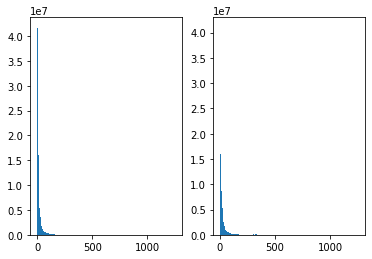

In [53]:
plt.subplot(1, 2, 1)
plt.hist(AmCrdtrs_matrix.reshape(-1), bins=200)

plt.subplot(1, 2, 2)
plt.hist(AmDbtrs_matrix.reshape(-1), bins=200)

plt.show()

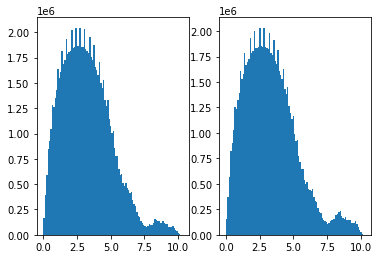

In [55]:
plt.subplot(1, 2, 1)
AmCrdtrs_matrix_log = np.log2(AmCrdtrs_matrix+1)
AmCrdtrs_matrix_log = np.round(AmCrdtrs_matrix_log, 2)
plt.hist(AmCrdtrs_matrix_log.reshape(-1), bins=100)

plt.subplot(1, 2, 2)
AmDbtrs_matrix_log = np.log2(AmDbtrs_matrix+1)
AmDbtrs_matrix_log = np.round(AmDbtrs_matrix_log, 2)
plt.hist(AmDbtrs_matrix_log.reshape(-1), bins=100)

plt.show()

In [56]:
AmCrdtrs_matrix_log_triu = np.triu(AmCrdtrs_matrix_log, k=1)
AmDbtrs_matrix_log_triu = np.triu(AmDbtrs_matrix_log, k=1)

In [57]:
AmCrdtrs_file = pd.DataFrame(AmCrdtrs_matrix_log_triu, index=all_families_AmCrdtrs_inds, columns=all_families_AmCrdtrs_inds)
AmCrdtrs_file.to_csv('data/AmCrdtrs_matrix.zip', compression={'method': 'zip', 'archive_name': 'AmCrdtrs_matrix.csv'})

In [58]:
AmDbtrs_file = pd.DataFrame(AmDbtrs_matrix_log_triu, index=all_families_AmDbtrs_inds, columns=all_families_AmDbtrs_inds)
AmDbtrs_file.to_csv('data/AmDbtrs_matrix.zip', compression={'method': 'zip', 'archive_name': 'AmDbtrs_matrix.csv'})

## family frstPrds & lstPrds & SmBnfts

In [63]:
def count_fam_frstPrds_and_lstPrds_and_SmBnfts(dataset, family):
    total_frstPrd_95, total_frstPrd_96, total_frstPrd_97, total_frstPrd_98 = 0, 0, 0, 0
    total_lstPrd_95, total_lstPrd_96, total_lstPrd_97, total_lstPrd_98 = 0, 0, 0, 0
    total_SmBnft_95, total_SmBnft_96, total_SmBnft_97, total_SmBnft_98 = 0, 0, 0, 0

    for person in family:
        cell = dataset.loc[dataset.ID == person]
        #frstPrds
        total_frstPrd_95 += list(cell['frstPrd_95'])[0]
        total_frstPrd_96 += list(cell['frstPrd_96'])[0]
        total_frstPrd_97 += list(cell['frstPrd_97'])[0]
        total_frstPrd_98 += list(cell['frstPrd_98'])[0]

        #lstPrds
        total_lstPrd_95 += list(cell['lstPrd_95'])[0]
        total_lstPrd_96 += list(cell['lstPrd_96'])[0]
        total_lstPrd_97 += list(cell['lstPrd_97'])[0]
        total_lstPrd_98 += list(cell['lstPrd_98'])[0]

        #SmBnfts
        total_SmBnft_95 += list(cell['SmBnft_95'])[0]
        total_SmBnft_96 += list(cell['SmBnft_96'])[0]
        total_SmBnft_97 += list(cell['SmBnft_97'])[0]
        total_SmBnft_98 += list(cell['SmBnft_98'])[0]
    
    all_data = [total_frstPrd_95, total_frstPrd_96, total_frstPrd_97, total_frstPrd_98, total_lstPrd_95, total_lstPrd_96, total_lstPrd_97, total_lstPrd_98, total_SmBnft_95, total_SmBnft_96, total_SmBnft_97, total_SmBnft_98]
    for i in range(len(all_data)):
        all_data[i] = logalize(all_data[i])
    
    return all_data[0:4], all_data[4:8], all_data[8:12]

In [65]:
family_frstPrds, family_lstPrds, family_SmBnfts = dict(), dict(), dict()
for parent, family in families.items():
    family_frstPrds[parent], family_lstPrds[parent], family_SmBnfts[parent] = count_fam_frstPrds_and_lstPrds_and_SmBnfts(dataset, family)

In [67]:
print(family_similarity_matrix(list(family_frstPrds.items())[0][1], list(family_frstPrds.items())[1][1]))
print(family_similarity_matrix(list(family_lstPrds.items())[0][1], list(family_lstPrds.items())[1][1]))
print(family_similarity_matrix(list(family_SmBnfts.items())[0][1], list(family_SmBnfts.items())[1][1]))

7.046428072167731
8.02410310809363
2.7117373965342386


In [69]:
all_families_frstPrds = np.array([list(family_frstPrds.items())[i][1] for i in trange(len(family_frstPrds))])
all_families_frstPrds_inds = [list(family_frstPrds.items())[i][0] for i in trange(len(family_frstPrds))]

all_families_frstPrds[0]

100%|██████████| 9473/9473 [02:07<00:00, 74.16it/s]


array([6.87506132, 7.39794003, 6.87506132, 6.69897009])

In [70]:
all_families_lstPrds = np.array([list(family_lstPrds.items())[i][1] for i in trange(len(family_lstPrds))])
all_families_lstPrds_inds = [list(family_lstPrds.items())[i][0] for i in trange(len(family_lstPrds))]

100%|██████████| 9473/9473 [02:13<00:00, 70.72it/s]


In [71]:
all_families_SmBnfts = np.array([list(family_SmBnfts.items())[i][1] for i in trange(len(family_SmBnfts))])
all_families_SmBnfts_inds = [list(family_SmBnfts.items())[i][0] for i in trange(len(family_SmBnfts))]

100%|██████████| 9473/9473 [02:05<00:00, 75.23it/s] 


In [112]:
print(calc_similarity_column(all_families_frstPrds, 0))
print(calc_similarity_column(all_families_lstPrds, 0))
print(calc_similarity_column(all_families_SmBnfts, 0))

[  0.           7.04642807  10.53327543 ... 300.23165194 305.18166229
 478.02970708]
[  0.           8.02410311  12.52477088 ... 296.99440965 299.7188654
 492.75814215]
[  0.           2.7117374    0.45309503 ... 265.31463999 429.0491943
 429.0491943 ]


In [73]:
frstPrds_matrix = np.array([calc_similarity_column(all_families_frstPrds, i) for i in trange(len(family_frstPrds))])

100%|██████████| 9473/9473 [00:10<00:00, 946.40it/s] 


In [74]:
lstPrds_matrix = np.array([calc_similarity_column(all_families_lstPrds, i) for i in trange(len(family_lstPrds))])

100%|██████████| 9473/9473 [00:09<00:00, 1009.70it/s]


In [75]:
SmBnfts_matrix = np.array([calc_similarity_column(all_families_SmBnfts, i) for i in trange(len(family_SmBnfts))])

100%|██████████| 9473/9473 [00:10<00:00, 938.54it/s] 


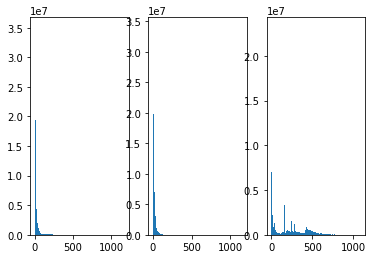

In [76]:
plt.subplot(1, 3, 1)
plt.hist(frstPrds_matrix.reshape(-1), bins=200)

plt.subplot(1, 3, 2)
plt.hist(lstPrds_matrix.reshape(-1), bins=200)

plt.subplot(1, 3, 3)
plt.hist(SmBnfts_matrix.reshape(-1), bins=200)

plt.show()

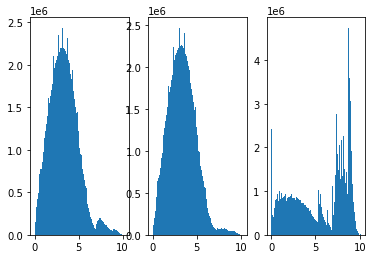

In [77]:
plt.subplot(1, 3, 1)
frstPrds_matrix_log = np.log2(frstPrds_matrix+1)
frstPrds_matrix_log = np.round(frstPrds_matrix_log, 2)
plt.hist(frstPrds_matrix_log.reshape(-1), bins=100)

plt.subplot(1, 3, 2)
lstPrds_matrix_log = np.log2(lstPrds_matrix+1)
lstPrds_matrix_log = np.round(lstPrds_matrix_log, 2)
plt.hist(lstPrds_matrix_log.reshape(-1), bins=100)

plt.subplot(1, 3, 3)
SmBnfts_matrix_log = np.log2(SmBnfts_matrix+1)
SmBnfts_matrix_log = np.round(SmBnfts_matrix_log, 2)
plt.hist(SmBnfts_matrix_log.reshape(-1), bins=100)

plt.show()

In [82]:
frstPrds_matrix_log_triu = np.triu(frstPrds_matrix_log, k=1)
lstPrds_matrix_log_triu = np.triu(lstPrds_matrix_log, k=1)
SmBnfts_matrix_log_triu = np.triu(SmBnfts_matrix_log, k=1)

In [84]:
frstPrds_file = pd.DataFrame(frstPrds_matrix_log_triu, index=all_families_frstPrds_inds, columns=all_families_frstPrds_inds)
frstPrds_file.to_csv('data/frstPrds_matrix.zip', compression={'method': 'zip', 'archive_name': 'frstPrds_matrix.csv'})

In [85]:
lstPrds_file = pd.DataFrame(lstPrds_matrix_log_triu, index=all_families_lstPrds_inds, columns=all_families_lstPrds_inds)
lstPrds_file.to_csv('data/lstPrds_matrix.zip', compression={'method': 'zip', 'archive_name': 'lstPrds_matrix.csv'})

In [86]:
SmBnfts_file = pd.DataFrame(SmBnfts_matrix_log_triu, index=all_families_SmBnfts_inds, columns=all_families_SmBnfts_inds)
SmBnfts_file.to_csv('data/SmBnfts_matrix.zip', compression={'method': 'zip', 'archive_name': 'SmBnfts_matrix.csv'})

## family_card98_and_card99

In [88]:
def count_fam_card98_and_card99(dataset, family):
    total_frstPrd_95, total_frstPrd_96, total_frstPrd_97, total_frstPrd_98 = 0, 0, 0, 0
    total_lstPrd_95, total_lstPrd_96, total_lstPrd_97, total_lstPrd_98 = 0, 0, 0, 0
    total_SmBnft_95, total_SmBnft_96, total_SmBnft_97, total_SmBnft_98 = 0, 0, 0, 0
    total_card98, total_card99 = 0, 0

    for person in family:
        cell = dataset.loc[dataset.ID == person]

        #card98
        total_card98 += list(cell['Card98_Rials'])[0]
        #card99
        total_card99 += list(cell['Card99_Rials'])[0]
    
    all_data = [logalize(total_card98), logalize(total_card99)]
    
    return all_data

In [89]:
family_frstPrds, family_lstPrds, family_SmBnfts = dict(), dict(), dict()
family_card98, family_card99 = dict(), dict()
for parent, family in families.items():
    [family_card98[parent], family_card99[parent]] = count_fam_card98_and_card99(dataset, family)

In [136]:
def family_card_similarity(family1, family2):
    return 10*(family1 - family2)**2

In [137]:
print(family_card_similarity(list(family_card98.items())[0][1], list(family_card98.items())[1][1]))
print(family_card_similarity(list(family_card99.items())[0][1], list(family_card99.items())[1][1]))

2.2079809566823103
2.294027593801229


In [138]:
all_families_card98 = np.array([list(family_card98.items())[i][1] for i in trange(len(family_card98))])
all_families_card98_inds = [list(family_card98.items())[i][0] for i in trange(len(family_card98))]

all_families_card99 = np.array([list(family_card99.items())[i][1] for i in trange(len(family_card99))])
all_families_card99_inds = [list(family_card99.items())[i][0] for i in trange(len(family_card99))]

all_families_card98[0]

100%|██████████| 9473/9473 [00:06<00:00, 1390.76it/s]


8.746897777715771

In [145]:
def calc_similarity_column_for_cards(all_families_card, i):
    family = all_families_card[i]
    return 10*pow(all_families_card-family, 2)

In [146]:
print(calc_similarity_column_for_cards(all_families_card98, 0))
print(calc_similarity_column_for_cards(all_families_card99, 0))

[0.00000000e+00 2.20798096e+00 2.69782309e-01 ... 5.86147688e+00
 2.20711054e-02 7.65082207e+02]
[  0.           2.29402759   5.88799707 ...   2.68811636   1.57667965
 751.32040527]


In [147]:
card98_matrix = np.array([calc_similarity_column_for_cards(all_families_card98, i) for i in trange(len(family_card98))])
card99_matrix = np.array([calc_similarity_column_for_cards(all_families_card99, i) for i in trange(len(family_card99))])

100%|██████████| 9473/9473 [00:00<00:00, 12350.71it/s]


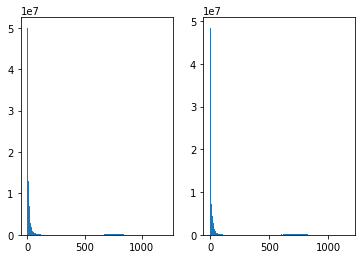

In [148]:
plt.subplot(1, 2, 1)
plt.hist(card98_matrix.reshape(-1), bins=200)

plt.subplot(1, 2, 2)
plt.hist(card99_matrix.reshape(-1), bins=200)

plt.show()

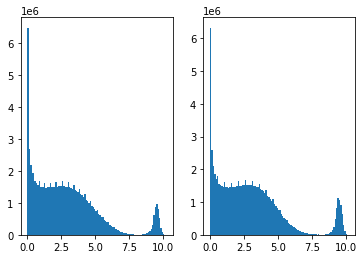

In [150]:
plt.subplot(1, 2, 1)
card98_matrix_log = np.log2(card98_matrix+1)
card98_matrix_log = np.round(card98_matrix_log, 2)
plt.hist(card98_matrix_log.reshape(-1), bins=100)

plt.subplot(1, 2, 2)
card99_matrix_log = np.log2(card99_matrix+1)
card99_matrix_log = np.round(card99_matrix_log, 2)
plt.hist(card99_matrix_log.reshape(-1), bins=100)

plt.show()

In [151]:
card98_matrix_log_triu = np.triu(card98_matrix_log, k=1)
card99_matrix_log_triu = np.triu(card99_matrix_log, k=1)

In [154]:
card98_file = pd.DataFrame(card98_matrix_log_triu, index=all_families_card98_inds, columns=all_families_card98_inds)
card98_file.to_csv('data/card98_matrix.zip', compression={'method': 'zip', 'archive_name': 'card98_matrix.csv'})

In [155]:
card99_file = pd.DataFrame(card99_matrix_log_triu, index=all_families_card99_inds, columns=all_families_card99_inds)
card99_file.to_csv('data/card99_matrix.zip', compression={'method': 'zip', 'archive_name': 'card99_matrix.csv'})

## Other

<AxesSubplot:ylabel='Frequency'>

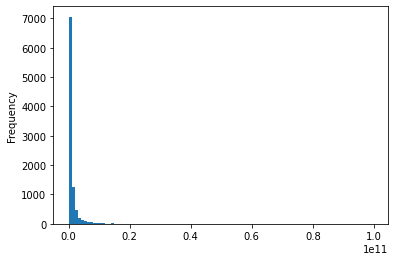

In [29]:
dataset.groupby('ParentID').agg({'Card98_Rials':'sum'})['Card98_Rials'].plot(kind='hist', bins=100)

<AxesSubplot:ylabel='Frequency'>

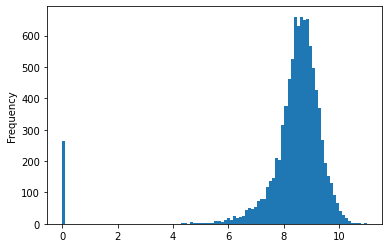

In [30]:
np.log10(dataset.groupby('ParentID').agg({'Card98_Rials':'sum'})['Card98_Rials'] + 1).plot(kind='hist', bins=100)